<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [1]:
'''
Here I import the same packages as in question 1
'''

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling as pp
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.feature_selection import RFECV, SelectFromModel


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [2]:
'''
Check the file locations to find the datasets that I want to load in
'''
ls


Ames Real Estate Data.xlsx      final data manipulations.ipynb
Ames_dataset.xlsx               fixed_col.csv
Data manipulation.ipynb         housing.csv*
Project-03-Q2.ipynb             lat_long_test.csv
README.md*                      lat_long_train.csv
Tbl_DataExportSpec.xls          new_full_set.csv
Untitled.ipynb                  new_housing.csv
ames.csv                        nfs2 - nfs2.csv
ames.twb                        nfs2.csv
ames_edit.csv                   project-03-Q1.ipynb*
data_description.txt*           project-03-Q3.ipynb
df1.csv                         test.csv
df2.csv                         test_data - df2.csv
df3.csv                         train.csv
df4.csv                         train_data - df1.csv
dfm.csv


In [3]:
'''
load in pre-cleaned datasets from question 1
'''

ames_X = pd.read_csv('./train.csv')
ames_y = pd.read_csv('./test.csv')


In [4]:
'''
Check column names
'''
ames_X.columns

Index(['Unnamed: 0', 'Id', 'Prop_Addr', 'Latitude', 'Longitude', 'MSZoning',
       'LotFrontage', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'MoSold_y',
       'YrSold

In [5]:
'''
Drop unrequired columns, save the columns that have been dropped into there own dataframe. Then standardise and dummify
variables in essentially the same way as we did in question 1
'''

drop_col = ames_X[['Prop_Addr', 'Id', 'Latitude', 'Longitude', 'OverallQual', 'OverallCond']].copy()
ames_X = ames_X.drop(['Unnamed: 0', 'Prop_Addr', 'Id', 'Latitude', 'Longitude', 'OverallQual', 'OverallCond'], axis=1).reset_index(drop=True)
ames_y = ames_y.drop(['Unnamed: 0'], axis=1).reset_index(drop=True)


In [6]:
ames_X_num = ames_X.select_dtypes(include = 'number')

In [7]:
ames_X_num = ames_X_num.astype(float)

In [8]:
ames_X_train = ames_X_num[ames_X_num.YrSold != 2010]
ames_X_test = ames_X_num[ames_X_num.YrSold == 2010]

In [9]:
ames_X_train_std = ames_X_train.drop(['YrSold'], axis=1)
ames_X_test_std = ames_X_test.drop(['YrSold'], axis=1)

In [10]:
ames_X_train_col = ames_X_train_std.columns
ames_X_test_col = ames_X_test_std.columns

In [11]:
ss=StandardScaler()

In [12]:
scaled_features_train = ss.fit_transform(ames_X_train_std)
scaled_features_test = ss.transform(ames_X_test_std)

In [13]:
df1 = pd.DataFrame(scaled_features_train)
df2 = pd.DataFrame(scaled_features_test)

In [14]:
df1.columns = ames_X_train_col
df2.columns = ames_X_test_col

In [15]:
ames_X_obj = ames_X.select_dtypes(include = 'object')

In [16]:
ames_X_obj.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [17]:
ames_X_obj = pd.get_dummies(ames_X_obj, drop_first=True, dtype=float)

In [18]:
ames_X_obj = pd.concat([ames_X_obj, ames_X_num['YrSold']], axis=1)

In [19]:
df3 = ames_X_obj[ames_X_obj.YrSold != 2010]
df4 = ames_X_obj[ames_X_obj.YrSold == 2010]

In [20]:
df3 = df3.drop(['YrSold'], axis=1)
df4 = df4.drop(['YrSold'], axis=1)

In [21]:
X_train = pd.concat([df1.reset_index(drop=True), df3.reset_index(drop=True)], axis=1)

In [22]:
y_train = pd.concat([df2.reset_index(drop=True), df4.reset_index(drop=True)], axis=1)

In [23]:
print(X_train.shape)
print(y_train.shape)

(1273, 188)
(171, 188)


In [24]:
X_test = ames_y[ames_y.YrSold != 2010]
y_test = ames_y[ames_y.YrSold == 2010]

In [25]:
X_train_label = X_test['sales_price']
y_train_label = y_test['sales_price']

In [26]:
print(X_train_label.shape)
print(y_train_label.shape)

(1273,)
(171,)


In [27]:
'''
As in question 1, we then model with linear regression and regularisation to get the co-efficients of the whole dataset.
I used GridsearchcV again, though this time I focussed on Lasso, as I wanted the strongest renovatable features to 
be used in my predicted improvements
'''

print(np.mean(X_train_label))
print(np.mean(y_train_label))

12.030939036390828
12.01738582825458


In [28]:
lr = LinearRegression()
lr.fit(X_train, X_train_label)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
print(lr.score(X_train, X_train_label))

0.9305673164743784


In [30]:
print(lr.score(y_train, y_train_label))

0.9110068552958898


In [31]:
scores = cross_val_score(lr, X_train, X_train_label, cv=20).mean()
print("Cross-validated scores:", scores)

Cross-validated scores: 0.7262152594074562


171


/Users/mbp15/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


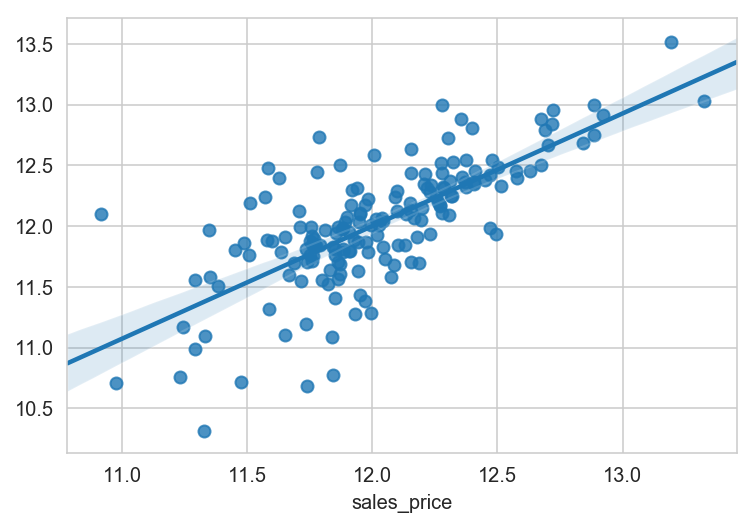

In [32]:
predictions = cross_val_predict(lr, y_train, y_train_label, cv=20)
print(len(predictions))
sns.regplot(y_train_label, predictions)

In [33]:
'''
From the cross validation, it can be seen that this model overfits quite significantly
'''

r2 = metrics.r2_score(y_train_label, predictions)
print("Cross-Predicted R2:", r2)

Cross-Predicted R2: 0.23982074886126659


In [34]:
# prepare a range of alpha values to test
alphas = np.array([10, 15, 20, 25, 30])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=5)
grid.fit(X_train, X_train_label)
ridge_score = grid.best_score_
ridge_best_est = grid.best_estimator_
ridge_best_params = grid.best_params_
# print(grid)
# summarize the results of the grid search
print(ridge_score)
print(ridge_best_est.alpha)
print(ridge_best_params)

0.8596830010907683
10
{'alpha': 10}


In [35]:
# prepare a range of alpha values to test
alphas = np.array([0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1])
# create and fit a ridge regression model, testing each alpha
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=5)
grid.fit(X_train, X_train_label)
lasso_score = grid.best_score_
lasso_best_est = grid.best_estimator_
lasso_coef = grid.best_estimator_.coef_
lasso_intercept = grid.best_estimator_.intercept_
lasso_predict = grid.best_estimator_.predict(y_train)
# print(grid)
# summarize the results of the grid search
print(lasso_score)
print(lasso_best_est.alpha)
print(lasso_intercept)
print(lasso_predict)

0.8579654595693962
0.0006
11.780291699007726
[11.9494542  11.97955143 11.80092489 12.54337254 12.1818384  11.78144934
 12.55802546 11.65705522 12.31776482 11.39181129 11.88340456 11.57030185
 11.64864691 11.3263708  11.66581027 12.23058733 12.13910394 12.07520073
 12.19393375 12.09288713 12.74557602 11.53013174 11.84262185 12.30060295
 12.44210267 12.43231772 12.4118773  12.2842434  11.82745359 12.0354142
 11.87809339 11.57835442 11.75507396 11.77188967 12.33763817 12.16459009
 12.19449223 11.73882941 12.3660519  12.38454756 11.47985081 11.78198405
 11.74212886 12.62111866 12.12624015 11.66612003 11.65343378 12.53372444
 12.25196079 11.50192303 11.62872384 11.79116707 12.12334778 11.70630326
 12.75810485 11.95750983 12.07078229 11.70739979 12.48954684 11.63373033
 11.81785715 12.26661763 12.21190965 12.40011547 11.43583025 12.36442363
 11.97975923 11.62942959 12.29212841 11.98642478 11.29913155 11.88072065
 11.76394517 11.98707831 11.7214705  11.91742944 11.45212493 11.73972868
 11.798

In [36]:
dfl = pd.DataFrame(data = lasso_coef, index = X_train.columns, columns=['coefs'])

dfl.reset_index()

dfl['feature'] = dfl.index

dfl.reset_index(drop=True)

dfl = dfl[dfl.coefs != 0]


In [37]:
dfl.shape

(85, 2)

In [38]:
ls

Ames Real Estate Data.xlsx      final data manipulations.ipynb
Ames_dataset.xlsx               fixed_col.csv
Data manipulation.ipynb         housing.csv*
Project-03-Q2.ipynb             lat_long_test.csv
README.md*                      lat_long_train.csv
Tbl_DataExportSpec.xls          new_full_set.csv
Untitled.ipynb                  new_housing.csv
ames.csv                        nfs2 - nfs2.csv
ames.twb                        nfs2.csv
ames_edit.csv                   project-03-Q1.ipynb*
data_description.txt*           project-03-Q3.ipynb
df1.csv                         test.csv
df2.csv                         test_data - df2.csv
df3.csv                         train.csv
df4.csv                         train_data - df1.csv
dfm.csv


In [39]:
'''
From Lasso, we are able to get the best co-efficients for predicting affects of renovations. We can observe that lasso
picked 85 features and removed 103 features. I removed all of the fixed features from question 1, then sorted what 
remained to get the renovatable features that had the greatest impact on price.
''' 

fixed = pd.read_csv('fixed_col.csv')

In [40]:
fixed['features'] = fixed['0']

In [41]:
fixed.drop(['Unnamed: 0', '0'], axis=1, inplace=True)

In [42]:
ff = []
for i in fixed.features:
    ff.append(i)

In [43]:
reno = []

for i in dfl.feature:
    if i in ff:
        pass
    else:
        reno.append(i)

In [44]:
reno = pd.DataFrame(data = reno, columns = ['feature'])

In [45]:
df_reno = pd.merge(reno, dfl, how ='left', on='feature')

In [46]:
df_reno_sorted = df_reno.sort_values(by=['coefs'], ascending=False)

In [47]:
df_reno_sorted.set_index(['feature'], drop=True, inplace=True)

Lasso picked 85 features and eliminated the other 103 features


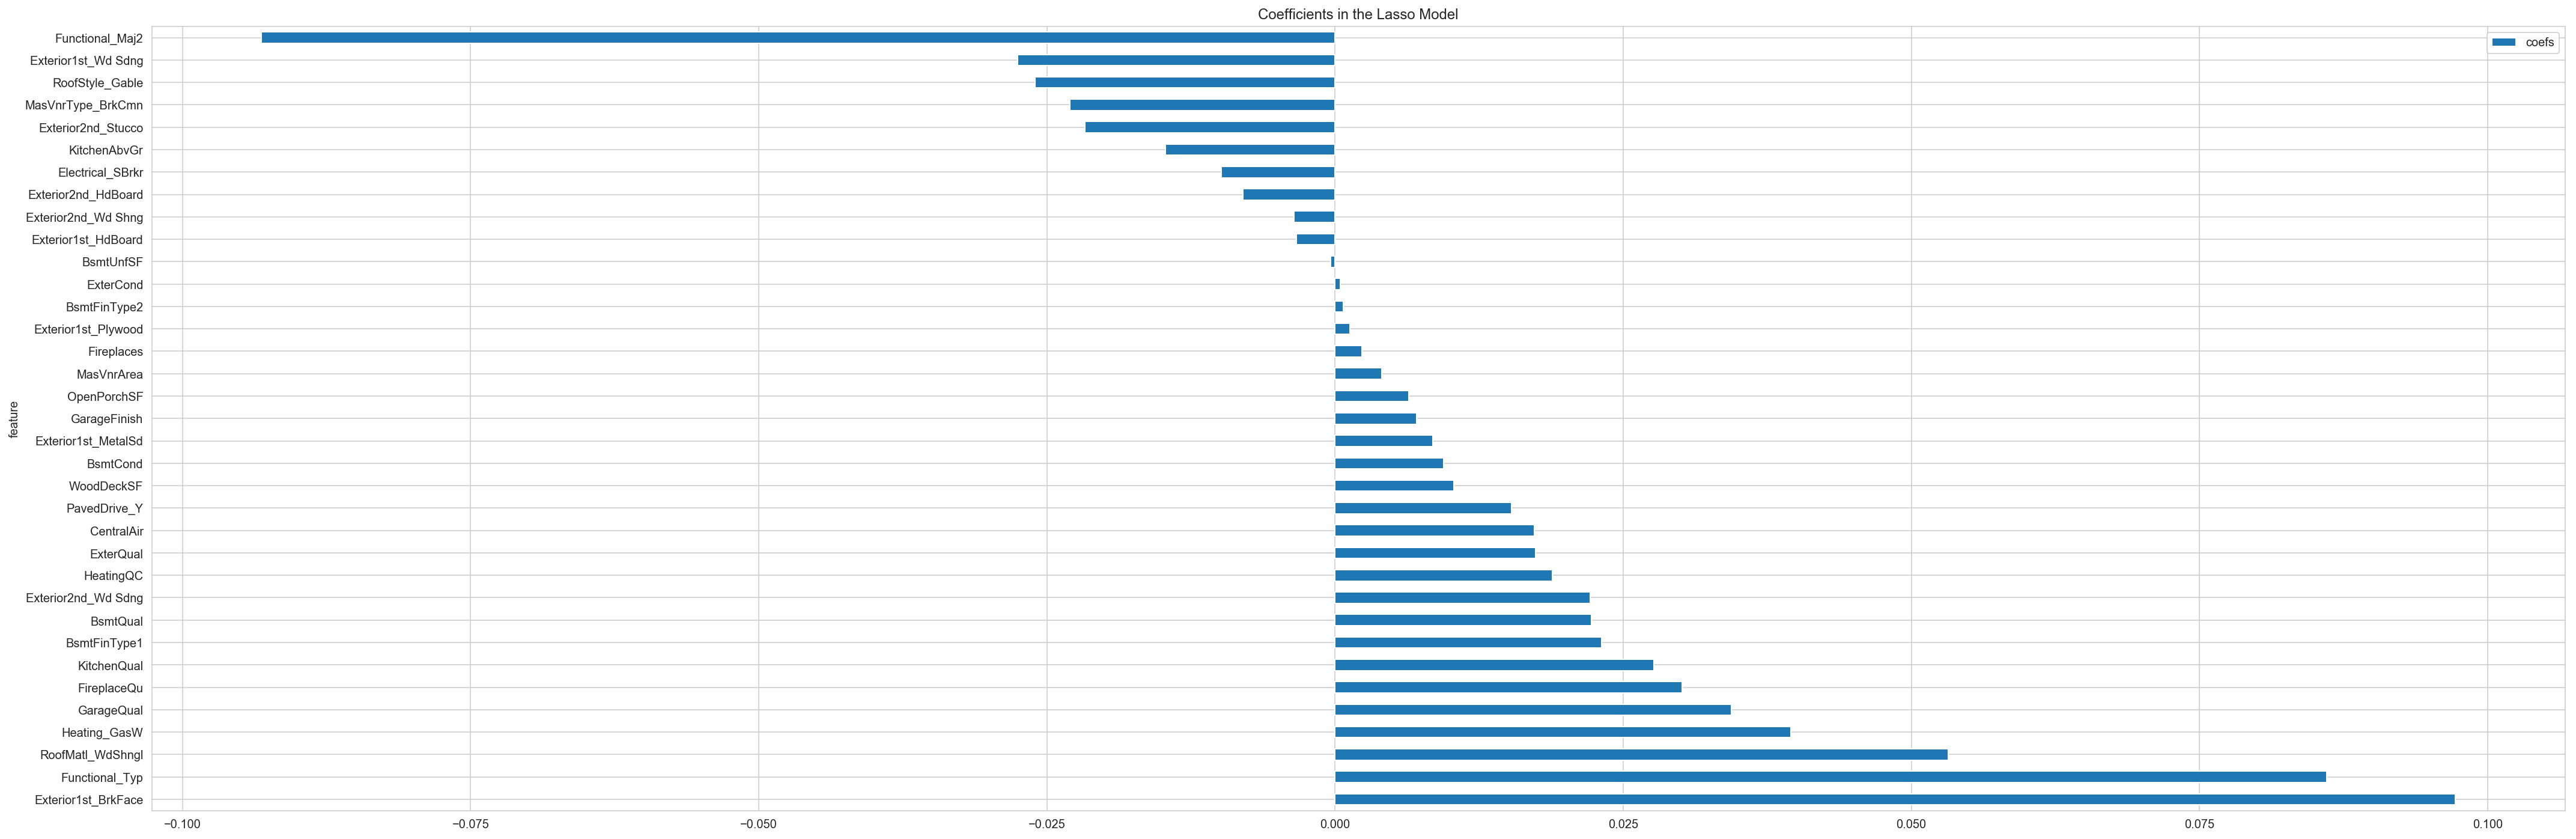

In [90]:
coefs = pd.Series(lasso_coef, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = df_reno_sorted #pd.concat([df_reno_sorted.head(10),
                     #df_reno_sorted.tail(10)])
imp_coefs.plot(kind = "barh")

plt.rcParams["figure.figsize"] = (24,12)
plt.title("Coefficients in the Lasso Model")
plt.show()

In [49]:
df_reno_sorted.head(6)

,coefs
feature,
Exterior1st_BrkFace,0.097217
Functional_Typ,0.086026
RoofMatl_WdShngl,0.053204
Heating_GasW,0.039561
GarageQual,0.034406
FireplaceQu,0.030097


From the above data investigation, we can conclude that the top five alterations we can make to our houses to effect positive price growth are: <br>

- exterior first to Brick faced
- roof material to wood shingle
- heating to gas water heating
- Garage Quality
- Fireplace Quality

- I have excluded functional from this list as I am not sure what Functional actually means.

In [50]:
df_reno_sorted.tail()

,coefs
feature,
Exterior2nd_Stucco,-0.021688
MasVnrType_BrkCmn,-0.023022
RoofStyle_Gable,-0.026006
Exterior1st_Wd Sdng,-0.027531
Functional_Maj2,-0.093147


From Lasso, we can see that the biggest positively correlated renovatable features that could be worked on are broadly:
- Overall Quality, which is the quality of materials and finish of the house, coef = 0.083746
- Whether the exterior of the house was faced in brick
- Whether the house has heat supplied through gas heated hot water or steam, 
- The overall condition of the house, coef = 0.043481
- The house having typical functionality <br>

We can see that the factors that negatively affect the property price are:
- Secondary exterior surfaces, particularly hardboard, wood shingles and Stucco
- The electrical system, particularly if it has standard circuit breakers and romex
- The funactionality of the property has major deductions <br>

Note: because Overall Condition and Overall Quality are aggregates of the total quality and conditions, I have decided to drop them and re-run the anaylsis to determine the most important individual factors.

Going back to the original code, I am going to introduce a modified feature category for the five renovatable features identified above (including nulling of columns that are also affected by the change) and return the predicted increase in house price

In [51]:
ames_X.columns

Index(['MSZoning', 'LotFrontage', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'MoSold_y',
       'YrSold', 'SaleType', 'SaleCondition', 'lot_area'],
      dtype='object')

In [52]:
'''
Here, I created the renovatable features at maximum performance, in order to calculate the maximum predicted price 
growth achievable by renovating the top five renovatable features.
'''

ames_Xr = ames_X

In [53]:
top5 = ames_Xr[['Exterior1st', 'Exterior2nd', 'RoofMatl', 'Heating', 'HeatingQC', 'GarageCond', 'GarageQual', 
               'GarageFinish', 'FireplaceQu']].copy

In [54]:
ames_Xr.Exterior1st = ['BrkFace' if row != 'BrkFace' else 'BrkFace' for row in ames_Xr['Exterior1st']]

In [55]:
ames_Xr.Exterior2nd = [0 if row != 0 else 0 for row in ames_Xr['Exterior2nd']]

In [56]:
ames_Xr.RoofMatl = ['WdShngl' if row != 'WdShngl' else 'WdShngl' for row in ames_Xr['RoofMatl']]

In [57]:
ames_Xr.Heating = ['GasW' if row != 'GasW' else 'GasW' for row in ames_Xr['Heating']]

In [58]:
ames_Xr.HeatingQC = [5 if row != 5 else 5 for row in ames_Xr['HeatingQC']]

In [59]:
ames_Xr.GarageCond = [5 if row != 5 else 5 for row in ames_Xr['GarageCond']]

In [60]:
ames_Xr.GarageQual = [5 if row != 5 else 5 for row in ames_Xr['GarageQual']]

In [61]:
ames_Xr.GarageFinish = [3 if row != 3 else 3 for row in ames_Xr['GarageFinish']]

In [62]:
ames_Xr.FireplaceQu = [5 if row != 5 else 5 for row in ames_Xr['FireplaceQu']]

In [63]:
ames_Xr.shape

(1444, 62)

In [64]:
ames_Xr_num = ames_Xr.select_dtypes(include = 'number')

In [65]:
ames_Xr_num = ames_Xr_num.astype(float)

In [66]:
ames_Xr_num_std = ames_Xr_num.drop(['YrSold'], axis=1)

In [67]:
ames_Xr_num_col = ames_Xr_num_std.columns

In [68]:
scaled_features = ss.fit_transform(ames_Xr_num_std)

In [69]:
df5 = pd.DataFrame(scaled_features)

In [70]:
df5.columns = ames_Xr_num_col

In [71]:
ames_Xr_obj = ames_Xr.select_dtypes(include = 'object')

In [72]:
df6 = pd.get_dummies(ames_X_obj, drop_first=True, dtype=float)

In [73]:
ames_R = pd.concat([df5.reset_index(drop=True), df6.reset_index(drop=True)], axis=1)

In [74]:
ames_R

,LotFrontage,YearBuilt,YearRemodAdd,Exterior2nd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,YrSold
0,0.217146,1.046905,0.871022,0.0,0.502669,1.051286,-0.239343,0.578488,0.114880,-0.587428,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2008.0
1,0.649800,0.144160,-0.444163,0.0,-0.572102,-0.703693,-0.239343,0.578488,0.114880,2.227549,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2007.0
2,0.303677,0.980035,0.822311,0.0,0.316229,1.051286,-0.239343,0.578488,0.114880,0.350897,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2008.0
3,0.072928,-1.895376,-0.736427,0.0,-0.572102,-0.703693,-0.239343,-0.559573,1.917999,-0.587428,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2006.0
4,0.765174,0.946600,0.724890,0.0,1.347132,1.051286,-0.239343,0.578488,0.114880,1.289223,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2008.0
5,0.794018,0.712555,0.481337,0.0,-0.572102,-0.703693,-0.239343,0.578488,0.114880,-0.587428,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2009.0
6,0.505582,1.080340,0.968443,0.0,0.447834,1.051286,-0.239343,1.716549,0.114880,1.289223,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2007.0
7,-1.657687,0.043855,-0.590295,0.0,0.743944,-0.703693,-0.239343,0.578488,0.114880,0.350897,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2009.0
8,-0.186664,-1.360416,-1.710638,0.0,-0.572102,-0.703693,-0.239343,-0.559573,0.114880,-0.587428,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2008.0
9,-0.215508,-1.092936,-1.710638,0.0,-0.572102,-0.703693,-0.239343,-0.559573,0.114880,-0.587428,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2008.0


In [75]:
X_train

,LotFrontage,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.219489,1.039558,0.873287,0.484357,1.047456,-0.243326,0.570867,0.108678,-0.590833,1.174724,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.651833,0.143829,-0.439508,-0.567921,-0.709344,-0.243326,0.570867,0.108678,2.201731,0.700287,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.305958,0.973208,0.824665,0.301819,1.047456,-0.243326,0.570867,0.108678,0.340021,1.174724,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.075374,-1.879857,-0.731241,-0.567921,-0.709344,-0.243326,-0.566400,1.905385,-0.590833,0.700287,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.767124,0.940033,0.727421,1.311148,1.047456,-0.243326,0.570867,0.108678,1.270876,1.174724,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0.795947,0.707807,0.484311,-0.567921,-0.709344,-0.243326,0.570867,0.108678,-0.590833,1.174724,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,0.507718,1.072734,0.970532,0.430670,1.047456,-0.243326,1.708134,0.108678,1.270876,1.174724,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,-1.654000,0.044303,-0.585375,0.720583,-0.709344,-0.243326,0.570867,0.108678,0.340021,0.700287,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,-0.184032,-1.349054,-1.703682,-0.567921,-0.709344,-0.243326,-0.566400,0.108678,-0.590833,-1.197458,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,-0.212855,-1.083653,-1.703682,-0.567921,-0.709344,-0.243326,-0.566400,0.108678,-0.590833,1.174724,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [76]:
ames_R = ames_R.drop(['YrSold', 'Exterior2nd'], axis=1)

In [77]:
ames_R.HeatingQC.value_counts()

0.0    1444
Name: HeatingQC, dtype: int64

In [78]:
ames_R.shape

(1444, 188)

In [89]:
ames_R.to_csv('./ames_R.csv')

In [79]:
best_reno = grid.best_estimator_.predict(ames_R)

In [80]:
br = pd.DataFrame(best_reno, columns = ['new_sales_price'])

In [81]:
br

,new_sales_price
0,12.240207
1,11.986104
2,12.282730
3,12.105163
4,12.579750
5,12.016813
6,12.438458
7,12.209114
8,11.707040
9,11.608492


In [83]:
dfm = pd.concat([ames_R, drop_col, ames_y, br], axis=1)

In [84]:
dfm

,LotFrontage,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,SaleCondition_Partial,Prop_Addr,Id,Latitude,Longitude,OverallQual,OverallCond,sales_price,YrSold,new_sales_price
0,0.217146,1.046905,0.871022,0.502669,1.051286,-0.239343,0.578488,0.114880,-0.587428,1.157140,...,0.0,821 MILLER AVE,1,42.015396,-93.686978,7,5,12.247694,2008,12.240207
1,0.649800,0.144160,-0.444163,-0.572102,-0.703693,-0.239343,0.578488,0.114880,2.227549,0.682719,...,0.0,2124 TORREY PINES RD,2,42.043182,-93.645305,6,8,12.109011,2007,11.986104
2,0.303677,0.980035,0.822311,0.316229,1.051286,-0.239343,0.578488,0.114880,0.350897,1.157140,...,0.0,718 WILDER BLVD,3,42.015930,-93.688636,7,5,12.317167,2008,12.282730
3,0.072928,-1.895376,-0.736427,-0.572102,-0.703693,-0.239343,-0.559573,1.917999,-0.587428,0.682719,...,0.0,504 ASH AVE,4,42.017729,-93.644027,7,5,11.849398,2006,12.105163
4,0.765174,0.946600,0.724890,1.347132,1.051286,-0.239343,0.578488,0.114880,1.289223,1.157140,...,0.0,3127 ALMOND RD,5,42.055872,-93.653959,8,5,12.429216,2008,12.579750
5,0.794018,0.712555,0.481337,-0.572102,-0.703693,-0.239343,0.578488,0.114880,-0.587428,1.157140,...,0.0,202 KEN MARIL RD,6,41.986257,-93.608949,5,5,11.870600,2009,12.016813
6,0.505582,1.080340,0.968443,0.447834,1.051286,-0.239343,1.716549,0.114880,1.289223,1.157140,...,0.0,2420 YORKSHIRE CIR,7,42.052909,-93.641561,8,5,12.634603,2007,12.438458
7,-1.657687,0.043855,-0.590295,0.743944,-0.703693,-0.239343,0.578488,0.114880,0.350897,0.682719,...,0.0,1636 JOHNSON ST,8,42.048975,-93.632873,7,6,12.206073,2009,12.209114
8,-0.186664,-1.360416,-1.710638,-0.572102,-0.703693,-0.239343,-0.559573,0.114880,-0.587428,-1.214964,...,0.0,1019 GRAND AVE,9,42.032008,-93.620691,7,5,11.774520,2008,11.707040
9,-0.215508,-1.092936,-1.710638,-0.572102,-0.703693,-0.239343,-0.559573,0.114880,-0.587428,1.157140,...,0.0,1301 RIDGEWOOD AVE,10,42.034729,-93.627974,5,6,11.678440,2008,11.608492


In [85]:
dfm['sales_price'] = np.exp(dfm['sales_price'])

In [86]:
dfm['new_sales_price'] = np.exp(dfm['new_sales_price'])

In [87]:
dfm['profitability'] = dfm['new_sales_price'] - dfm['sales_price']

In [88]:
dfm.to_csv('./dfm.csv')

In [ ]:
# rfecv = RFECV(estimator = lr, step = 1, cv=10)
# selector = rfecv.fit(X_train, X_train_label)
# selector.ranking_

# X_train_new = selector.transform(X_train)

# param_grid = {'alpha': sp_rand()}
# # create and fit a ridge regression model, testing random alpha values
# model = Ridge()
# rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
# rsearch.fit(train_X_new, train_Y_new)
# expected = train_X_new
# predicted = model.predict(train_Y_new)
# # summarize the fit of the model
# mse = np.mean((predicted-expected)**2)
# print "MSE and Model Score: "
# print(mse)
# print(model.score(train_X_new, train_Y_new))

In [ ]:
# # Number of best features
# rfecv.n_features_

In [ ]:
# X_train_new = rfecv.transform(X_train)

In [ ]:
# prepare a range of alpha values to test
parameters = {'alpha': [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
              'l1_ratio': (0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1)}


# create and fit a ridge regression model, testing each alpha
model = ElasticNet()
grid = GridSearchCV(estimator=model, param_grid=parameters,cv=5)
grid.fit(X_train, X_train_label)
enet_score = grid.best_score_
enet_best_est = grid.best_estimator_
# print(grid)
# summarize the results of the grid search
print(enet_score)
print(enet_best_est.l1_ratio)
print(enet_best_est.alpha)



In [ ]:
# dfs = pd.DataFrame(data =rfecv.ranking_, index = X_train.columns, columns=['rfecv_rank'])

In [ ]:
# dfs.reset_index()

In [ ]:
# dfs['feature'] = dfs.index

In [ ]:
# dfs.reset_index(drop=True)

In [ ]:
# dfss = dfs[dfs.rfecv_rank == 1]

In [ ]:
# dfss

In [ ]:
# fixed = ['Id', 'MSZoning', 'lot_area', 'LotShape', 'LotFrontage',
#             'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BedroomAbvGr',
#             'Condition2', 'BldgType', 'HouseStyle',   'YearBuilt', 'YearRemodAdd', 'Foundation', 
#             'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
#             'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'FullBath', 'HalfBath',
#             'TotRmsAbvGrd', 'MoSold_y', 'YrSold', 'SaleType', 'SaleCondition', 'Latitude', 'Longitude']

In [ ]:
# reno = []
# for i in dfss.feature:
#     if i in fixed:
#         pass
#     else:
#         reno.append(i)

In [ ]:
# reno


In [ ]:
# # We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
# clf = LassoCV(cv=5)

# # Set a minimum threshold of 0.25
# sfm = SelectFromModel(clf, threshold=0.01)
# sfm.fit(X_train, X_train_label)
# n_features = sfm.transform(X_train).shape[1]

# # Reset the threshold till the number of features equals two.
# # Note that the attribute can be set directly instead of repeatedly
# # fitting the metatransformer.
# while n_features > 2:
#     sfm.threshold += 0.01
#     X_transform = sfm.transform(X_train)
#     n_features = X_transform.shape[1]

# # Plot the selected two features from X.
# plt.title(
#     "Features selected from Boston using SelectFromModel with "
#     "threshold %0.3f." % sfm.threshold)
# feature1 = X_transform[:, 0]
# feature2 = X_transform[:, 1]
# plt.plot(feature1, feature2, 'r.')
# plt.xlabel("Feature number 1")
# plt.ylabel("Feature number 2")
# plt.ylim([np.min(feature2), np.max(feature2)])
# plt.show()